# Seasonality Trading Strategy

## Model
Based on analysis, certain stocks exhibit **seasonal patterns** with higher returns in specific quarters:
- **Stock C**: Seasonal in Q1 (Jan-Mar) and Q4 (Oct-Dec)
- **Stocks K and M**: Seasonal in Q4 only (Oct-Dec)

## Strategy
- **BUY** on the first trading day of the seasonal quarter
- **SELL** on the last trading day of the seasonal quarter
- **FLAT** (no position) outside seasonal quarters

This is a simple calendar-based strategy that exploits predictable seasonal effects.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Parameters
TRANSACTION_COST_BPS = 10
INITIAL_CAPITAL = 100000

## 1. Load Data and Parse Dates

In [26]:
# Load data
df = pd.read_csv('simulated_prices.csv')

# Parse the date format: Y0-M01-D02 -> Year 0, Month 01, Day 02
def parse_date(date_str):
    parts = date_str.split('-')
    year = int(parts[0][1:])   # Y0 -> 0
    month = int(parts[1][1:])  # M01 -> 1
    day = int(parts[2][1:])    # D02 -> 2
    return year, month, day

df['Year'], df['Month'], df['Day'] = zip(*df['Date'].apply(parse_date))

# Define quarters
def get_quarter(month):
    if month <= 3:
        return 1
    elif month <= 6:
        return 2
    elif month <= 9:
        return 3
    else:
        return 4

df['Quarter'] = df['Month'].apply(get_quarter)

print(f"Data: {len(df)} trading days")
print(f"Years: {df['Year'].min()} to {df['Year'].max()}")
print(f"\nSample of parsed dates:")
print(df[['Date', 'Year', 'Month', 'Day', 'Quarter']].head(10))

Data: 2521 trading days
Years: 0 to 9

Sample of parsed dates:
         Date  Year  Month  Day  Quarter
0  Y0-M01-D02     0      1    2        1
1  Y0-M01-D05     0      1    5        1
2  Y0-M01-D06     0      1    6        1
3  Y0-M01-D07     0      1    7        1
4  Y0-M01-D08     0      1    8        1
5  Y0-M01-D09     0      1    9        1
6  Y0-M01-D12     0      1   12        1
7  Y0-M01-D13     0      1   13        1
8  Y0-M01-D14     0      1   14        1
9  Y0-M01-D15     0      1   15        1


## 2. Define Seasonal Periods

In [27]:
# Seasonal stocks and their active quarters
SEASONAL_STOCKS = {
    'C': [1, 4],  # Q1 and Q4
    'K': [4],     # Q4 only
    'M': [4],     # Q4 only
}

# Create indicator for whether we should be in position
for stock, quarters in SEASONAL_STOCKS.items():
    df[f'{stock}_in_season'] = df['Quarter'].isin(quarters)

# Show seasonal periods
print("Seasonal Trading Periods:")
print("  Stock C: Q1 (Jan 1 - Mar 31) and Q4 (Oct 1 - Dec 31)")
print("  Stocks K, M: Q4 only (Oct 1 - Dec 31)")
print(f"\nDays in season per stock:")
for stock in SEASONAL_STOCKS:
    in_season = df[f'{stock}_in_season'].sum()
    print(f"  {stock}: {in_season} days ({in_season/len(df)*100:.1f}%)")

Seasonal Trading Periods:
  Stock C: Q1 (Jan 1 - Mar 31) and Q4 (Oct 1 - Dec 31)
  Stocks K, M: Q4 only (Oct 1 - Dec 31)

Days in season per stock:
  C: 1235 days (49.0%)
  K: 590 days (23.4%)
  M: 590 days (23.4%)


## 3. Backtest Function

In [28]:
def backtest_seasonality(prices, in_season, initial_capital=100000, 
                         position_pct=1.0, transaction_cost_bps=10):
    """
    Backtest seasonality strategy.
    
    Args:
        prices: array of stock prices
        in_season: boolean array indicating if we should be in position
        initial_capital: starting capital
        position_pct: fraction of capital to use per position
        transaction_cost_bps: transaction cost in basis points
    
    Returns:
        equity: array of portfolio values
        trades: list of trade details
    """
    n = len(prices)
    tc_rate = transaction_cost_bps / 10000
    
    position = 0  # 0 = flat, 1 = long
    shares = 0
    cash = initial_capital
    entry_price = 0
    entry_day = 0
    
    equity = []
    trades = []
    positions = []  # Track position for plotting
    
    for day in range(n):
        price = prices[day]
        should_be_in = in_season[day]
        
        # Entry: not in position but should be
        if position == 0 and should_be_in:
            shares = int(cash * position_pct / price)
            cost = shares * price * (1 + tc_rate)
            cash -= cost
            position = 1
            entry_price = price
            entry_day = day
        
        # Exit: in position but shouldn't be
        elif position == 1 and not should_be_in:
            proceeds = shares * price * (1 - tc_rate)
            cash += proceeds
            pnl = shares * (price - entry_price) - shares * price * tc_rate - shares * entry_price * tc_rate
            trades.append({
                'entry_day': entry_day,
                'exit_day': day,
                'entry_price': entry_price,
                'exit_price': price,
                'shares': shares,
                'pnl': pnl,
                'return': (price - entry_price) / entry_price,
                'holding_days': day - entry_day
            })
            position = 0
            shares = 0
        
        # Calculate equity
        equity.append(cash + shares * price)
        positions.append(position)
    
    # Force close at end if still in position
    if position == 1:
        price = prices[-1]
        proceeds = shares * price * (1 - tc_rate)
        cash += proceeds
        pnl = shares * (price - entry_price) - shares * price * tc_rate - shares * entry_price * tc_rate
        trades.append({
            'entry_day': entry_day,
            'exit_day': n - 1,
            'entry_price': entry_price,
            'exit_price': price,
            'shares': shares,
            'pnl': pnl,
            'return': (price - entry_price) / entry_price,
            'holding_days': n - 1 - entry_day,
            'forced_close': True
        })
        equity[-1] = cash
    
    return np.array(equity), trades, np.array(positions)


def calc_metrics(equity, trades, initial_capital=100000):
    """Calculate performance metrics."""
    total_return = (equity[-1] - initial_capital) / initial_capital
    daily_returns = np.diff(equity) / equity[:-1]
    
    # Sharpe ratio (annualized)
    sharpe = np.sqrt(252) * daily_returns.mean() / daily_returns.std() if daily_returns.std() > 0 else 0
    
    # Max drawdown
    running_max = np.maximum.accumulate(equity)
    drawdown = (equity - running_max) / running_max
    max_dd = drawdown.min()
    
    # Trade statistics
    if trades:
        trades_df = pd.DataFrame(trades)
        win_rate = (trades_df['pnl'] > 0).mean()
        avg_return = trades_df['return'].mean()
        avg_holding = trades_df['holding_days'].mean()
    else:
        win_rate = 0
        avg_return = 0
        avg_holding = 0
    
    return {
        'total_return': total_return,
        'sharpe': sharpe,
        'max_dd': max_dd,
        'n_trades': len(trades),
        'win_rate': win_rate,
        'avg_return': avg_return,
        'avg_holding': avg_holding
    }

## 4. Run Backtest for Each Seasonal Stock

In [29]:
results = {}

for stock, quarters in SEASONAL_STOCKS.items():
    prices = df[stock].values
    in_season = df[f'{stock}_in_season'].values
    
    equity, trades, positions = backtest_seasonality(
        prices, in_season, 
        initial_capital=INITIAL_CAPITAL,
        transaction_cost_bps=TRANSACTION_COST_BPS
    )
    
    metrics = calc_metrics(equity, trades, INITIAL_CAPITAL)
    
    # Buy and hold benchmark
    bh_shares = int(INITIAL_CAPITAL / prices[0])
    bh_equity = bh_shares * prices + (INITIAL_CAPITAL - bh_shares * prices[0])
    bh_metrics = calc_metrics(bh_equity, [], INITIAL_CAPITAL)
    
    results[stock] = {
        'equity': equity,
        'trades': trades,
        'positions': positions,
        'metrics': metrics,
        'bh_equity': bh_equity,
        'bh_metrics': bh_metrics,
        'prices': prices,
        'quarters': quarters
    }

print("Backtest complete for all seasonal stocks.")

Backtest complete for all seasonal stocks.


## 5. Results Summary

In [30]:
print("="*80)
print("SEASONALITY TRADING STRATEGY - RESULTS")
print("="*80)

print(f"\n{'Stock':<8} {'Seasons':<12} {'Return':>10} {'Sharpe':>8} {'Max DD':>10} {'Trades':>8} {'Win Rate':>10} {'B&H Ret':>10}")
print("-"*80)

for stock, data in results.items():
    m = data['metrics']
    bh = data['bh_metrics']
    quarters_str = ','.join([f'Q{q}' for q in data['quarters']])
    print(f"{stock:<8} {quarters_str:<12} {m['total_return']*100:>9.1f}% {m['sharpe']:>8.2f} {m['max_dd']*100:>9.1f}% {m['n_trades']:>8} {m['win_rate']*100:>9.0f}% {bh['total_return']*100:>9.1f}%")

print("-"*80)

SEASONALITY TRADING STRATEGY - RESULTS

Stock    Seasons          Return   Sharpe     Max DD   Trades   Win Rate    B&H Ret
--------------------------------------------------------------------------------
C        Q1,Q4            401.7%     0.63     -45.3%       10        70%     119.9%
K        Q4               278.5%     0.60     -35.7%        9        67%     360.1%
M        Q4               180.5%     0.60     -31.7%        9        56%     163.8%
--------------------------------------------------------------------------------


In [31]:
# Show trades for each stock
for stock, data in results.items():
    print(f"\n{stock} Trades (Seasonal in {','.join([f'Q{q}' for q in data['quarters']])})")
    print("-"*70)
    for i, tr in enumerate(data['trades']):
        forced = ' (forced)' if tr.get('forced_close') else ''
        print(f"  {i+1:2}. Day {tr['entry_day']:4} -> {tr['exit_day']:4}: "
              f"${tr['entry_price']:.2f} -> ${tr['exit_price']:.2f} | "
              f"PnL: ${tr['pnl']:>8,.0f} ({tr['return']*100:>5.1f}%) | "
              f"{tr['holding_days']:3}d{forced}")


C Trades (Seasonal in Q1,Q4)
----------------------------------------------------------------------
   1. Day    0 ->   63: $177.55 -> $137.33 | PnL: $ -22,821 (-22.7%) |  63d
   2. Day  194 ->  325: $180.85 -> $243.53 | PnL: $  26,521 ( 34.7%) | 131d
   3. Day  456 ->  586: $132.93 -> $112.07 | PnL: $ -16,462 (-15.7%) | 130d
   4. Day  716 ->  846: $275.74 -> $317.11 | PnL: $  12,886 ( 15.0%) | 130d
   5. Day  976 -> 1106: $198.35 -> $276.67 | PnL: $  39,234 ( 39.5%) | 130d
   6. Day 1237 -> 1368: $204.99 -> $261.96 | PnL: $  38,366 ( 27.8%) | 131d
   7. Day 1499 -> 1629: $205.55 -> $362.88 | PnL: $ 135,442 ( 76.5%) | 130d
   8. Day 1760 -> 1890: $405.84 -> $394.62 | PnL: $  -9,268 ( -2.8%) | 130d
   9. Day 2021 -> 2151: $339.07 -> $370.94 | PnL: $  27,919 (  9.4%) | 130d
  10. Day 2281 -> 2411: $260.30 -> $394.27 | PnL: $ 169,844 ( 51.5%) | 130d

K Trades (Seasonal in Q4)
----------------------------------------------------------------------
   1. Day  194 ->  260: $215.26 -> $163.0

## 6. Visualization

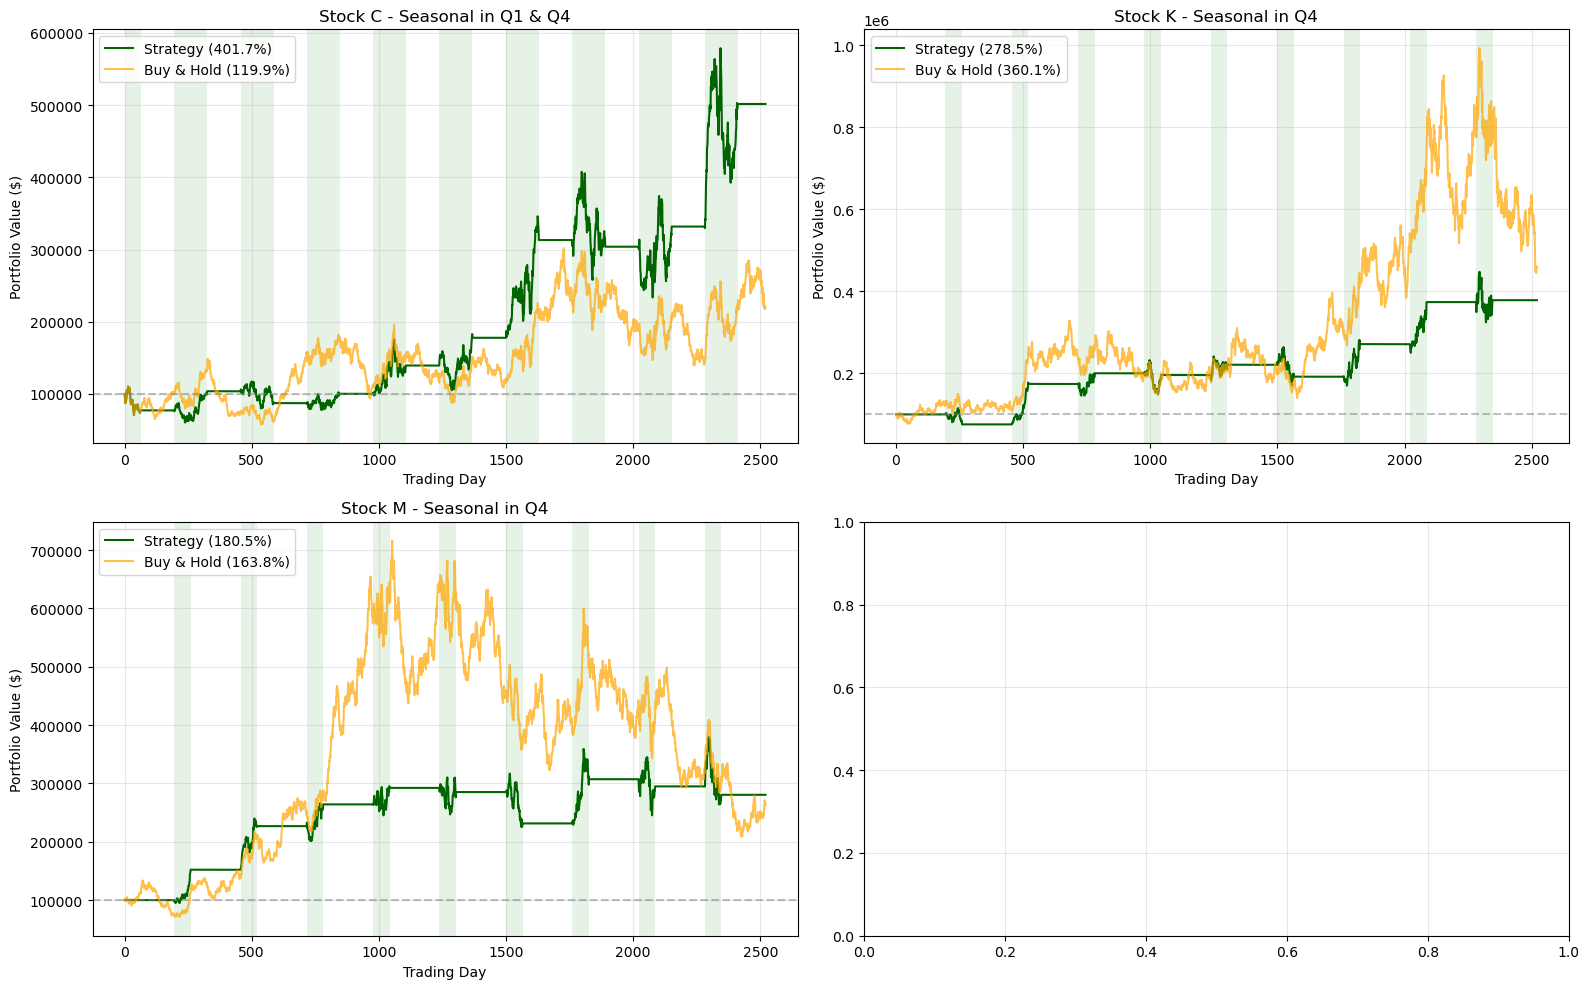

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (stock, data) in enumerate(results.items()):
    ax = axes[idx]
    
    # Plot equity curves
    ax.plot(data['equity'], color='darkgreen', linewidth=1.5, 
            label=f"Strategy ({data['metrics']['total_return']*100:.1f}%)")
    ax.plot(data['bh_equity'], color='orange', linewidth=1.5, alpha=0.7,
            label=f"Buy & Hold ({data['bh_metrics']['total_return']*100:.1f}%)")
    
    # Shade seasonal periods
    in_season = df[f'{stock}_in_season'].values
    for i in range(len(in_season)):
        if in_season[i]:
            ax.axvspan(i, i+1, alpha=0.1, color='green', linewidth=0)
    
    ax.axhline(INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Trading Day')
    ax.set_ylabel('Portfolio Value ($)')
    quarters_str = ' & '.join([f'Q{q}' for q in data['quarters']])
    ax.set_title(f'Stock {stock} - Seasonal in {quarters_str}')
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

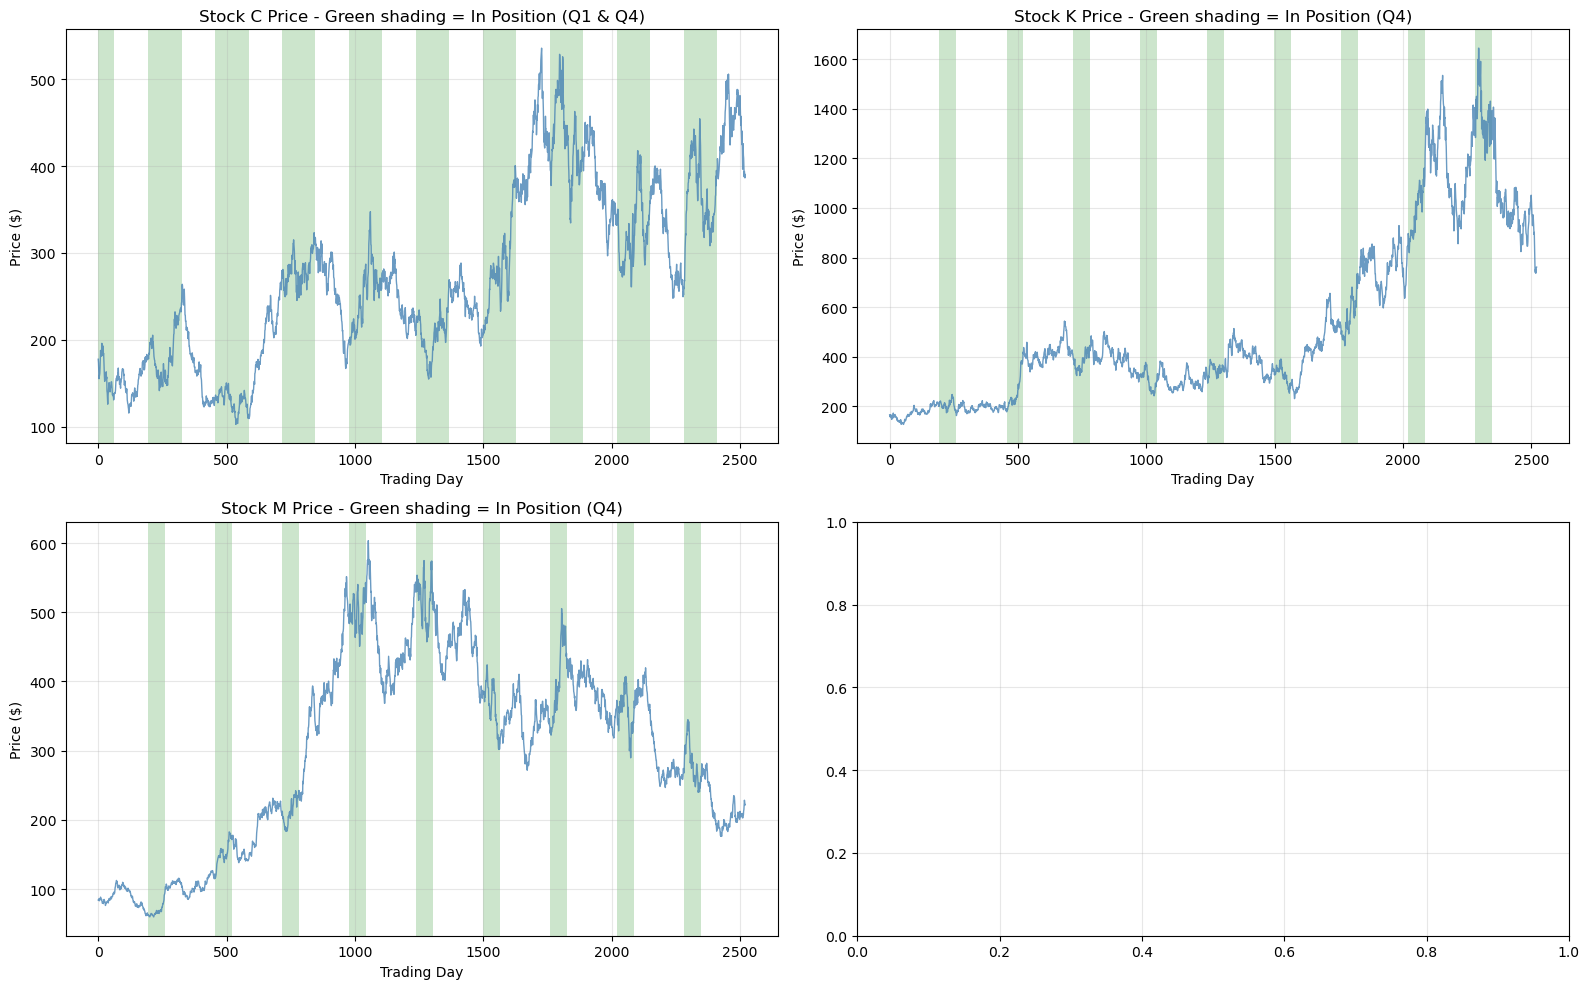

In [33]:
# Plot price with positions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (stock, data) in enumerate(results.items()):
    ax = axes[idx]
    
    # Plot price
    ax.plot(data['prices'], color='steelblue', linewidth=1, alpha=0.8)
    
    # Shade when in position
    positions = data['positions']
    for i in range(len(positions)):
        if positions[i] == 1:
            ax.axvspan(i, i+1, alpha=0.2, color='green', linewidth=0)
    
    ax.set_xlabel('Trading Day')
    ax.set_ylabel('Price ($)')
    quarters_str = ' & '.join([f'Q{q}' for q in data['quarters']])
    ax.set_title(f'Stock {stock} Price - Green shading = In Position ({quarters_str})')

plt.tight_layout()
plt.show()

## 7. Combined Portfolio

In [34]:
# Create a combined portfolio with equal weight to each seasonal stock
n_stocks = len(SEASONAL_STOCKS)
capital_per_stock = INITIAL_CAPITAL / n_stocks

combined_equity = np.zeros(len(df))
combined_bh_equity = np.zeros(len(df))

for stock, data in results.items():
    # Scale equity to per-stock allocation
    stock_equity = data['equity'] * (capital_per_stock / INITIAL_CAPITAL)
    stock_bh = data['bh_equity'] * (capital_per_stock / INITIAL_CAPITAL)
    combined_equity += stock_equity
    combined_bh_equity += stock_bh

# Calculate combined metrics
combined_return = (combined_equity[-1] - INITIAL_CAPITAL) / INITIAL_CAPITAL
combined_daily = np.diff(combined_equity) / combined_equity[:-1]
combined_sharpe = np.sqrt(252) * combined_daily.mean() / combined_daily.std()
combined_running_max = np.maximum.accumulate(combined_equity)
combined_dd = ((combined_equity - combined_running_max) / combined_running_max).min()

# B&H metrics
bh_return = (combined_bh_equity[-1] - INITIAL_CAPITAL) / INITIAL_CAPITAL
bh_daily = np.diff(combined_bh_equity) / combined_bh_equity[:-1]
bh_sharpe = np.sqrt(252) * bh_daily.mean() / bh_daily.std()
bh_running_max = np.maximum.accumulate(combined_bh_equity)
bh_dd = ((combined_bh_equity - bh_running_max) / bh_running_max).min()

print("="*70)
print("COMBINED PORTFOLIO (Equal weight: C, K, M)")
print("="*70)
print(f"\n{'Metric':<25} {'Seasonality':>15} {'Buy & Hold':>15}")
print("-"*55)
print(f"{'Total Return':<25} {combined_return*100:>14.1f}% {bh_return*100:>14.1f}%")
print(f"{'Sharpe Ratio':<25} {combined_sharpe:>15.2f} {bh_sharpe:>15.2f}")
print(f"{'Max Drawdown':<25} {combined_dd*100:>14.1f}% {bh_dd*100:>14.1f}%")
print(f"{'Final Value':<25} ${combined_equity[-1]:>13,.0f} ${combined_bh_equity[-1]:>13,.0f}")

COMBINED PORTFOLIO (Equal weight: C, K, M)

Metric                        Seasonality      Buy & Hold
-------------------------------------------------------
Total Return                       286.9%          214.6%
Sharpe Ratio                         0.86            0.53
Max Drawdown                       -19.8%          -42.4%
Final Value               $      386,888 $      314,607


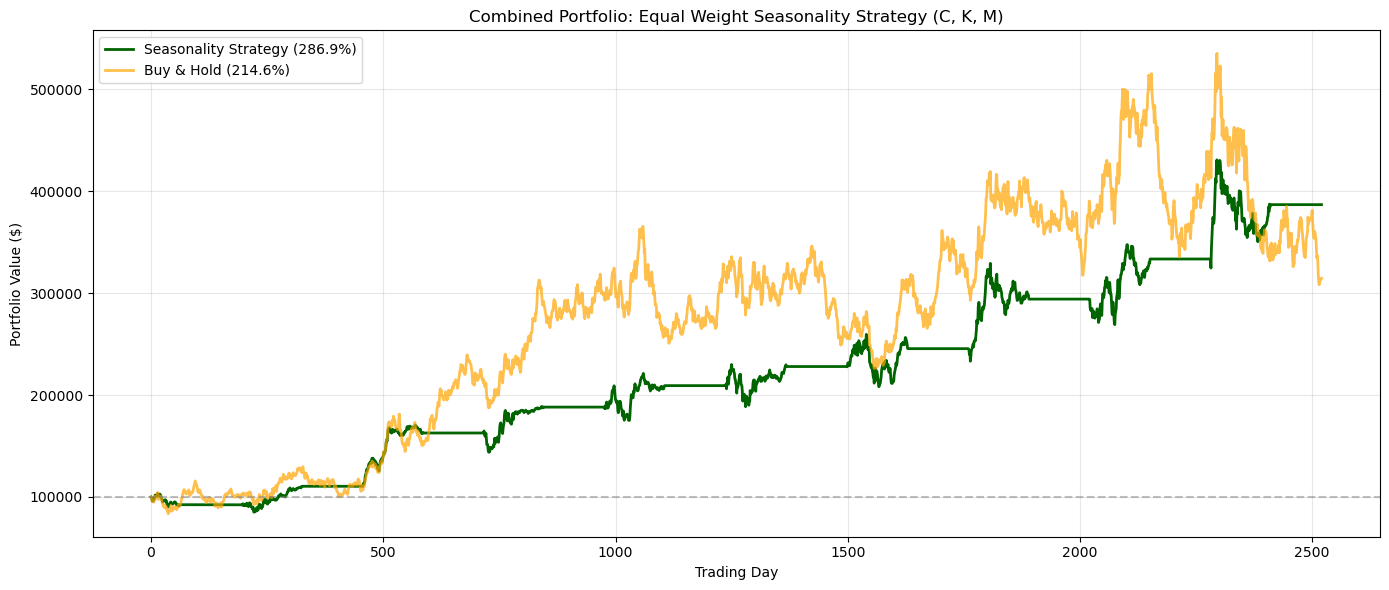

In [35]:
# Plot combined portfolio
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(combined_equity, color='darkgreen', linewidth=2, 
        label=f'Seasonality Strategy ({combined_return*100:.1f}%)')
ax.plot(combined_bh_equity, color='orange', linewidth=2, alpha=0.7,
        label=f'Buy & Hold ({bh_return*100:.1f}%)')
ax.axhline(INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel('Trading Day')
ax.set_ylabel('Portfolio Value ($)')
ax.set_title('Combined Portfolio: Equal Weight Seasonality Strategy (C, K, M)')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

## 8. Summary

In [36]:
print("="*70)
print("SEASONALITY TRADING STRATEGY - SUMMARY")
print("="*70)

print("\nStrategy Rules:")
print("  - Stock C: Long during Q1 (Jan-Mar) and Q4 (Oct-Dec)")
print("  - Stocks K, M: Long during Q4 only (Oct-Dec)")
print("  - Flat (no position) outside seasonal quarters")
print(f"  - Transaction cost: {TRANSACTION_COST_BPS} bps per trade")

print("\nKey Findings:")
for stock, data in results.items():
    m = data['metrics']
    bh = data['bh_metrics']
    outperform = m['total_return'] - bh['total_return']
    symbol = '+' if outperform > 0 else ''
    print(f"  {stock}: {m['total_return']*100:.1f}% return ({symbol}{outperform*100:.1f}% vs B&H), "
          f"Sharpe {m['sharpe']:.2f}, {m['n_trades']} trades, {m['win_rate']*100:.0f}% win rate")

print(f"\nCombined Portfolio:")
print(f"  Return: {combined_return*100:.1f}% (vs {bh_return*100:.1f}% B&H)")
print(f"  Sharpe: {combined_sharpe:.2f} (vs {bh_sharpe:.2f} B&H)")
print(f"  Max DD: {combined_dd*100:.1f}% (vs {bh_dd*100:.1f}% B&H)")

print("\nCaveats:")
print("  - No slippage or market impact modeled")
print("  - Assumes full capital deployment in seasonal periods")
print("  - Past seasonality may not persist in the future")

SEASONALITY TRADING STRATEGY - SUMMARY

Strategy Rules:
  - Stock C: Long during Q1 (Jan-Mar) and Q4 (Oct-Dec)
  - Stocks K, M: Long during Q4 only (Oct-Dec)
  - Flat (no position) outside seasonal quarters
  - Transaction cost: 10 bps per trade

Key Findings:
  C: 401.7% return (+281.8% vs B&H), Sharpe 0.63, 10 trades, 70% win rate
  K: 278.5% return (-81.6% vs B&H), Sharpe 0.60, 9 trades, 67% win rate
  M: 180.5% return (+16.7% vs B&H), Sharpe 0.60, 9 trades, 56% win rate

Combined Portfolio:
  Return: 286.9% (vs 214.6% B&H)
  Sharpe: 0.86 (vs 0.53 B&H)
  Max DD: -19.8% (vs -42.4% B&H)

Caveats:
  - No slippage or market impact modeled
  - Assumes full capital deployment in seasonal periods
  - Past seasonality may not persist in the future
